In [1]:
#!pip install -U datasets seqeval

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np
from seqeval.metrics import classification_report, f1_score, accuracy_score
import os
import requests
import zipfile

import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)} # converts labels to indices

In [5]:
# Extract sentences and labels
def extract_sentences_and_labels(dataset_split):
    sentences = []
    labels = []
    for item in dataset_split:
        sentences.append(item['tokens'])
        labels.append(item['ner_tags'])
    return sentences, labels

train_sentences, train_labels = extract_sentences_and_labels(dataset['train'])
test_sentences, test_labels = extract_sentences_and_labels(dataset['test'])

# Ensure labels are integers (handles string labels if present)
train_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in train_labels]
test_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in test_labels]

# Download and load GloVe embeddings
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url)
    with open("glove.6B.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
        zip_ref.extractall()

# Load GloVe vectors
glove_model = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_model[word] = vector

# Build vocabulary and embeddings matrix
all_words = set(word for sentence in train_sentences for word in sentence)
vocab = {word: idx + 2 for idx, word in enumerate(all_words)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

embedding_matrix = np.zeros((len(vocab), 100))
for word, i in vocab.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(100,))

In [6]:
# Prepare input sequences and pad
MAX_LEN = 512
def encode_sentence(sentence):
    ids = [vocab.get(word, 1) for word in sentence]
    return ids[:MAX_LEN] + [0] * (MAX_LEN - len(ids))

def encode_labels(label_seq):
    return label_seq[:MAX_LEN] + [0] * (MAX_LEN - len(label_seq))

X_train = [encode_sentence(sent) for sent in train_sentences]
y_train = [encode_labels(lbls) for lbls in train_labels]
X_test = [encode_sentence(sent) for sent in test_sentences]
y_test = [encode_labels(lbls) for lbls in test_labels]

# Convert to tensors
X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

In [7]:
torch.set_float32_matmul_precision("high")

In [8]:
# Define BiLSTM Model
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x

# Hyperparameters
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)

Step 0: Train loss 1.3613, Test loss 1.3629
Step 200: Train loss 0.7054, Test loss 0.6807
Step 400: Train loss 0.3894, Test loss 0.4165
Step 600: Train loss 0.2953, Test loss 0.3228
Step 800: Train loss 0.2257, Test loss 0.2566
Step 1000: Train loss 0.1987, Test loss 0.2430
Step 1200: Train loss 0.1874, Test loss 0.2168
Step 1400: Train loss 0.1705, Test loss 0.2291
Step 1600: Train loss 0.1131, Test loss 0.2058
Step 1800: Train loss 0.1196, Test loss 0.1714


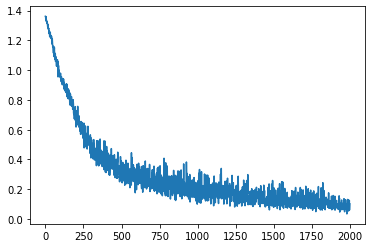

In [9]:
batch_size = 32

# Flattened dataset for random access (emulates get_batch)
train_dataset = list(zip(X_train, y_train))
test_dataset = list(zip(X_test, y_test))

def get_batch(dataset, batch_size):
    ix = torch.randint(len(dataset), (batch_size,))
    x = torch.stack([dataset[i][0] for i in ix]).to(device)
    y = torch.stack([dataset[i][1] for i in ix]).to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model, eval_steps=10):
    out = {}
    model.eval()
    for name, dataset in [("train", train_dataset), ("test", test_dataset)]:
        losses = torch.zeros(eval_steps)
        for k in range(eval_steps):
            x, y = get_batch(dataset, batch_size)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1), ignore_index=0)
            losses[k] = loss.item()
        out[name] = losses.mean().item()
    model.train()
    return out

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

max_iters = 2000
eval_interval = 200

# Training loop
lossi = []
for step in range(max_iters):
    if step % eval_interval == 0:
        losses = estimate_loss(model)
        print(f"Step {step}: Train loss {losses['train']:.4f}, Test loss {losses['test']:.4f}")
    
    xb, yb = get_batch(train_dataset, batch_size)
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        logits = model(xb)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), yb.view(-1), ignore_index=0)
    lossi.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


plt.plot(lossi)

In [10]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    pred_labels = torch.argmax(predictions, dim=2).cpu().numpy()

true_labels = y_test.cpu().numpy()

# Format for evaluation
true_str = []
pred_str = []
for t_seq, p_seq in zip(true_labels, pred_labels):
    temp_true = []
    temp_pred = []
    for t, p in zip(t_seq, p_seq):
        if t != 0:
            temp_true.append(labels[t])
            temp_pred.append(labels[p])
    true_str.append(temp_true)
    pred_str.append(temp_pred)

# Detailed evaluation report
print("Classification Report:\n")
print(classification_report(true_str, pred_str))
print("F1 Score:", f1_score(true_str, pred_str))
print("Accuracy:", accuracy_score(true_str, pred_str))

Classification Report:

              precision    recall  f1-score   support

          AC       0.91      0.95      0.93       797
          LF       0.77      0.86      0.81       482

   micro avg       0.86      0.92      0.89      1279
   macro avg       0.84      0.91      0.87      1279
weighted avg       0.86      0.92      0.89      1279

F1 Score: 0.8852830188679246
Accuracy: 0.9265762170790104
